# APDS-9960 Gesture Data Playground

Experimenting with different methods of processing APDS-9960 gesture data

## Gesture Data Formats

Gesture data is gathered by the sensor and stored in a 32-block FIFO which can be read via I2C either one block at a time or in a "page read" of the entire FIFO all at once. Each "block" is referred to in the datasheet as a "dataset".

Individual "datasets" are effectively a four-byte tuple of 8-bit unsigned ints. Each contains ADC count data from the "up", "down", "left", and "right" photodiodes, in that sequence. `0` represents "far" and `255` represents "near".

Here's a single sample of what that data looks like.

In [30]:
dataset_example = (123, 152, 151, 33)

And these are some sequences of datasets captured during normal use with test driver code.

These were collected with the following settings:

```py
apds.gesture_proximity_threshold = 5
apds.gesture_exit_threshold = 100
apds.gesture_exit_persistence = 2
apds.gesture_fifo_threshold = 1
apds.gesture_wait_time = 2
apds.gesture_gain = 1
apds.gesture_pulses = 8
apds.gesture_pulse_length = 1
```

In [31]:
up_swipe = [
    (98, 16, 56, 70),
    (141, 38, 89, 108),
    (194, 73, 131, 151),
    (255, 122, 179, 203),
    (255, 186, 242, 255),
    (238, 255, 231, 230),
    (187, 228, 182, 188),
    (136, 186, 136, 152),
    (93, 147, 96, 118),
    (57, 106, 61, 86),
    (31, 74, 36, 59),
    (16, 49, 18, 39),
    (6, 29, 9, 26),
    (0, 14, 0, 12)]

down_swipe = [
    (35, 81, 45, 83),
    (83, 136, 89, 129),
    (141, 184, 138, 175),
    (197, 218, 184, 211),
    (241, 235, 222, 236),
    (255, 246, 247, 254),
    (255, 253, 255, 255),
    (255, 253, 255, 255),
    (255, 233, 248, 255),
    (255, 209, 214, 255),
    (255, 172, 173, 248),
    (240, 130, 132, 207),
    (186, 81, 84, 153),
    (130, 36, 49, 104),
    (81, 11, 21, 59),
    (43, 0, 5, 27),
    (18, 0, 0, 10)]

left_swipe = [
    (55, 74, 93, 38),
    (101, 118, 141, 83),
    (150, 151, 171, 132),
    (181, 166, 174, 167),
    (198, 173, 170, 186),
    (203, 166, 157, 190),
    (197, 158, 149, 185),
    (187, 151, 142, 176),
    (172, 141, 132, 165),
    (162, 131, 121, 157),
    (151, 121, 110, 150),
    (143, 116, 98, 135),
    (125, 101, 88, 128),
    (111, 88, 71, 116),
    (94, 72, 49, 99),
    (69, 51, 26, 79),
    (45, 30, 8, 53),
    (24, 13, 0, 28)]

right_swipe = [
    (65, 47, 21, 90),
    (106, 84, 55, 132),
    (163, 126, 103, 182),
    (217, 169, 158, 218),
    (254, 198, 209, 232),
    (255, 212, 244, 236),
    (255, 215, 255, 235),
    (255, 215, 255, 231),
    (255, 213, 255, 232),
    (255, 216, 253, 234),
    (255, 225, 255, 243),
    (255, 239, 255, 254),
    (255, 249, 255, 255),
    (255, 249, 255, 255),
    (255, 245, 255, 255),
    (255, 244, 255, 255),
    (255, 248, 255, 255),
    (255, 248, 255, 255),
    (255, 247, 255, 238),
    (255, 237, 255, 213),
    (227, 222, 244, 183),
    (192, 203, 217, 148),
    (154, 176, 185, 116),
    (116, 148, 152, 89),
    (87, 121, 123, 64),
    (62, 95, 94, 46),
    (43, 74, 73, 33),
    (32, 58, 57, 27),
    (22, 46, 44, 18)]

The data within these cells represents the ADC counts recorded during a gesture measurement. The analog measurements represent reflections returned from pulses of an IR LED. In these data, `0` represents "far" and `255` represents "near".

We can process this a few different ways, which is where the fun really starts.

In [32]:
def gesture_decode_arduino_lib(gesture_data):
    gesture_motion = "none"
    
    if not gesture_data:
        return 0

    # if (0, 0, 0, 0) in (gesture_data):
    #     print("GEST ANALYSIS | Junk data, all zeroes present")
    #     return 0

    if len(gesture_data) > 0:
        # print("GEST ANALYSIS | Start Gesture Analysis")

        zeroes = (0, 0, 0, 0)
        first_data = zeroes
        last_data = zeroes
        GESTURE_THRESHOLD_OUT = 30

        # Find first/last values
        for early_gesture_tuple in gesture_data:
            # if [(gv > thr) for gv, thr in zip(early_gesture_tuple, GESTURE_THRESHOLD_OUT)]
            if (early_gesture_tuple[0] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[1] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[2] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[3] > GESTURE_THRESHOLD_OUT):
                    first_data = early_gesture_tuple
                    break # Stop iterating on our first hit

        # print("GEST ANALYSIS | First: {}".format(first_data))

        for reverse_gesture_tuple in reversed(gesture_data):
            if (reverse_gesture_tuple[0] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[1] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[2] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[3] > GESTURE_THRESHOLD_OUT):
                    last_data = reverse_gesture_tuple
                    break # Stop iterating on our first hit

        # print("GEST ANALYSIS | Last:  {}".format(last_data))

        if first_data == zeroes or last_data == zeroes:
            # print("GEST ANALYSIS | Junk data, all under useful thresholds")
            return gesture_data

        # Ratios and Deltas
        ud_ratio_first = ((first_data[0] - first_data[1]) * 100) / (first_data[0] + first_data[1])
        lr_ratio_first = ((first_data[2] - first_data[3]) * 100) / (first_data[2] + first_data[3])
        ud_ratio_last = ((last_data[0] - last_data[1]) * 100) / (last_data[0] + last_data[1])
        lr_ratio_last = ((last_data[2] - last_data[3]) * 100) / (last_data[2] + last_data[3])


        # Calculate delta betwen first and last ratios
        ud_delta = ud_ratio_last - ud_ratio_first
        lr_delta = lr_ratio_last - lr_ratio_first

        # print("GEST ANALYSIS | UD Ratio | First: {}, Last: {}, Delta: {}".format(ud_ratio_first, ud_ratio_last, ud_delta))
        # print("GEST ANALYSIS | LR Ratio | First: {}, Last: {}, Delta: {}".format(lr_ratio_first, lr_ratio_last, lr_delta))

        # Accumulate UD/LR deltas
        # gesture_ud_delta += ud_delta ## These are class vars in the actual code but we don't need to persist anything
        # gesture_lr_delta += lr_delta
        gesture_ud_delta = ud_delta
        gesture_lr_delta = lr_delta

        GESTURE_SENSITIVITY_1 = 50
        # GESTURE_SENSITIVITY_2 = 20

        # Basic Gesture Determination
        # Determine U/D Gesture
        if gesture_ud_delta >= GESTURE_SENSITIVITY_1:
            gesture_ud_count = 1
        elif gesture_ud_delta <= -GESTURE_SENSITIVITY_1:
            gesture_ud_count = -1
        else:
            gesture_ud_count = 0

        # Determine L/R Gesture
        if gesture_lr_delta >= GESTURE_SENSITIVITY_1:
            gesture_lr_count = 1
        elif gesture_lr_delta <= -GESTURE_SENSITIVITY_1:
            gesture_lr_count = -1
        else:
            gesture_lr_count = 0
        
        ## This relies on global vars so we won't be using this either
        # # Determine Near/Far Gesture
        # if gesture_ud_count == 0 and gesture_lr_count == 0:
        #     if abs(ud_delta) < GESTURE_SENSITIVITY_2 and \
        #         abs(lr_delta) < GESTURE_SENSITIVITY_2:

        #         # if ud_delta == 0 and lr_delta == 0:
        #         #     gesture_near_count += 1
        #         # elif ud_delta != 0 and lr_delta != 0:
        #         #     gesture_far_count += 1

        #         # if gesture_near_count >= 10 and gesture_far_count >= 2:
        #         #     if ud_delta == 0 and lr_delta == 0:
        #         #         gesture_state = "near"
        #         #     elif ud_delta != 0 and lr_delta != 0:
        #         #         gesture_state = "far"
        # else:
        #     if abs(ud_delta) < GESTURE_SENSITIVITY_2 and \
        #         abs(lr_delta) < GESTURE_SENSITIVITY_2:
        #         if ud_delta == 0 and lr_delta == 0:
        #             gesture_near_count += 1
                
        #         if gesture_near_count >= 10:
        #             gesture_ud_count = 0
        #             gesture_lr_count = 0
        #             gesture_ud_delta = 0
        #             gesture_lr_delta = 0
        

        # Determine swipe direction
        if gesture_ud_count == -1 and gesture_lr_count == 0:
            gesture_motion = "up"
        elif gesture_ud_count == 1 and gesture_lr_count == 0:
            gesture_motion = "down"
        elif gesture_ud_count == 0 and gesture_lr_count == 1:
            gesture_motion = "right"
        elif gesture_ud_count == 0 and gesture_lr_count == -1:
            gesture_motion = "left"
        elif gesture_ud_count == -1 and gesture_lr_count == 1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "up"
            else:
                gesture_motion = "down"
        elif gesture_ud_count == 1 and gesture_lr_count == -1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "down"
            else:
                gesture_motion = "left"
        elif gesture_ud_count == -1 and gesture_lr_count == -1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "up"
            else:
                gesture_motion = "left"
        elif gesture_ud_count == 1 and gesture_lr_count == 1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "down"
            else:
                gesture_motion = "right"
        else:
            # return 0
            pass            
        
        # print("GEST DECODE   | Globals | state: {}, motion: {}".format(gesture_state, gesture_motion))
        
        return gesture_motion

    return gesture_motion

print(" Up    | {}".format(gesture_decode_arduino_lib(up_swipe)))
print(" Down  | {}".format(gesture_decode_arduino_lib(down_swipe)))
print(" Left  | {}".format(gesture_decode_arduino_lib(left_swipe)))
print(" Right | {}".format(gesture_decode_arduino_lib(right_swipe)))

 Up    | up
 Down  | down
 Left  | left
 Right | right


That's a lot of work though and it fails to work properly in some rare cases.

One idea is to try and identify intersting looking frames with a clear "start" or "stop" signal.

These are cases where one channel is markedly higher than the others or markedly lower than the others.

The above code handles this by identifying a "ratio" for up/down and left/right. There may be more elegant options though.

In [33]:
dataset_tuple = up_swipe[0]

def dataset_ratios(dataset):
    ud = ((dataset[0] - dataset[1]) * 100) / (dataset[0] + dataset[1])
    lr = ((dataset[2] - dataset[3]) * 100) / (dataset[2] + dataset[3])
    return ud, lr

def dataset_ratios_int(dataset):
    ud = ((dataset[0] - dataset[1]) * 100) // (dataset[0] + dataset[1])
    lr = ((dataset[2] - dataset[3]) * 100) // (dataset[2] + dataset[3])
    return ud, lr

ud_ratio, lr_ratio = dataset_ratios(dataset_tuple)
print("ud_r: {}, lr_r: {}".format(ud_ratio, lr_ratio))
ud_ratio, lr_ratio = dataset_ratios_int(dataset_tuple)
print("ud_r: {}, lr_r: {}".format(ud_ratio, lr_ratio))

ud_r: 71.9298245614035, lr_r: -11.11111111111111
ud_r: 71, lr_r: -12


This is useful since it gives is a quick approximation of whether there's a coherent signal in this dataset, especially if we look at it over time.

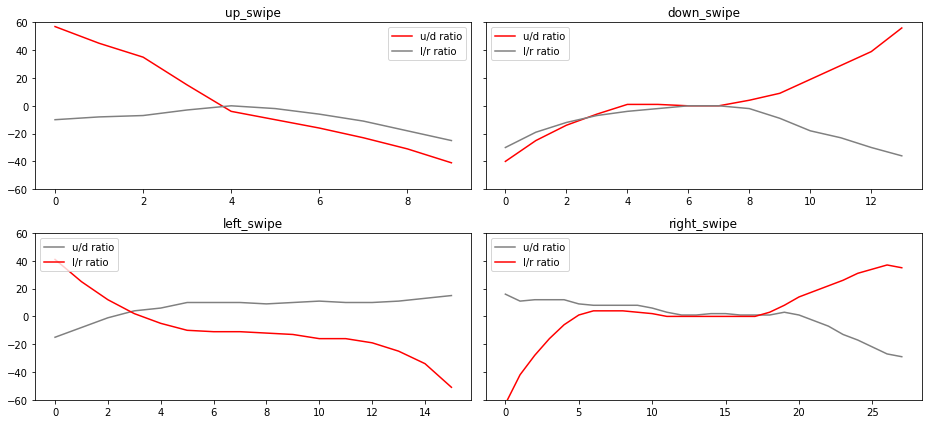

In [34]:
def gesture_ratios(dataset):
    ud_ratios = []
    lr_ratios = []
    for data in dataset:
        if all(x > 20 for x in data): # Prune out low-count entries that'll cause issues with our ratio math
            ud_ratio, lr_ratio = dataset_ratios_int(data)
            ud_ratios.append(ud_ratio)
            lr_ratios.append(lr_ratio)
            # print("{:<3d} {:<3d} {:<3d} {:<3d} | ud_r: {:< 4d} | lr_r: {:< 4d}".format(*data, ud_ratio, lr_ratio))
    return ud_ratios, lr_ratios

udr_ups, lrr_ups = gesture_ratios(up_swipe)
udr_downs, lrr_downs = gesture_ratios(down_swipe)
udr_lefts, lrr_lefts = gesture_ratios(left_swipe)
udr_rights, lrr_rights = gesture_ratios(right_swipe)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(13,6))
axs[0,0].set_title("up_swipe")
axs[0,0].plot(udr_ups, color="red", label="u/d ratio")
axs[0,0].plot(lrr_ups, color="gray", label="l/r ratio")
axs[0,0].set(ylim=(-60, 60))
axs[0,0].legend(loc="upper right")

axs[0,1].title.set_text("down_swipe")
axs[0,1].plot(udr_downs, color="red", label="u/d ratio")
axs[0,1].plot(lrr_downs, color="gray", label="l/r ratio")
axs[0,1].legend(loc="upper left")
axs[0,1].set(ylim=(-60, 60))

axs[1,0].title.set_text("left_swipe")
axs[1,0].plot(udr_lefts, color="gray", label="u/d ratio")
axs[1,0].plot(lrr_lefts, color="red", label="l/r ratio")
axs[1,0].legend(loc="upper left")
axs[1,0].set(ylim=(-60, 60))

axs[1,1].title.set_text("right_swipe")
axs[1,1].plot(udr_rights, color="gray", label="u/d ratio")
axs[1,1].plot(lrr_rights, color="red", label="l/r ratio")
axs[1,1].legend(loc="upper left")
axs[1,1].set(ylim=(-60, 60))

fig.tight_layout()
plt.show()

The signal in these ratios is pretty easy to see visually. There's typically a sharp difference (rise or fall) at the front with another sharp difference (rise or fall) toward the end. We can also determine direction of movement across the U/D or L/R sensor pair by the increase or decrease in values over time.